### Obtained Perplexity: -8.68, Coherence: 0.31, Best Number of Topics= 50

In [1]:
#Basic Libraries
import re
import numpy as np
import pandas as pd
from pprint import pprint
import sys
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
# spacy for lemmatization
import spacy
# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

from topic_model_function import *

In [2]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [13]:
#Load Dataset
df=pd.read_csv('/Users/mahika.p/OneDrive - Cornell University/Anxiety/Topic_based_Gap_Analysis/Anxiety/Data/CSV/medium_text_2016.csv')
df = df.iloc[::2, :]
#getting rid of NaN
df=df.replace(np.nan, '', regex=True)
#Combining title and text
df["Post"] = df["title"] + df["text"]
#Now that we don't need Title or Text, we drop those columns before saving the file
df=df.drop(['title', 'text'], axis = 1)

In [14]:
df=df.loc[:, ~df.columns.str.contains('^Unnamed')]

In [15]:
df.tail()

,year,Post
2748,2016,2016–2017It’s a New Year. It feels like it’s b...
2750,2016,i want to beYou know that dream where it’s sud...
2752,2016,carry yourself with the air of normalcybreathe...
2754,2016,"WordsIn the letter, I apologized and reconcile..."
2756,2016,"safety is relative, anyway, i supposesplitting..."


In [16]:
# Convert to list
data=df.Post.values.tolist()
# Remove new line characters
data=[re.sub('\s+', ' ', sent) for sent in data]
# Remove distracting single quotes
data=[re.sub("\'", "", sent) for sent in data]

In [17]:
#Function to clean up text
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True)) 

In [18]:
#Clean up text
data_words=list(sent_to_words(data))
print(data_words[:1])

[['minutes', 'of', 'uber', 'induced', 'title', 'the', 'actual', 'thoughts', 'of', 'person', 'with', 'generalized', 'anxiety', 'disorder', 'trusting', 'total', 'stranger', 'to', 'drive', 'her', 'around', 'for', 'almost', 'half', 'an', 'hour', 'date', 'december', 'time', 'pm', 'pickup', 'location', 'san', 'francisco', 'international', 'airport', 'departures', 'terminal', 'door', 'destination', 'home', 'after', 'day', 'trip', 'to', 'ohio', 'visiting', 'my', 'family', 'wait', 'for', 'my', 'uber', 'driver', 'to', 'arrive', 'he', 'driving', 'black', 'prius', 'just', 'like', 'every', 'other', 'uber', 'driver', 'tonight', 'notice', 'for', 'the', 'first', 'time', 'that', 'the', 'phone', 'app', 'shows', 'the', 'license', 'plate', 'number', 'that', 'handy', 'manage', 'to', 'avoid', 'getting', 'into', 'the', 'wrong', 'car', 'the', 'driver', 'loads', 'my', 'suitcase', 'in', 'the', 'trunk', 'and', 'asks', 'me', 'which', 'route', 'usually', 'take', 'home', 've', 'never', 'been', 'asked', 'this', 'bef

In [19]:
# Build the bigram and trigram models
bigram=gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram=gensim.models.Phrases(bigram[data_words], threshold=100)

In [20]:
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod=gensim.models.phrases.Phraser(bigram)
trigram_mod=gensim.models.phrases.Phraser(trigram)

In [21]:
# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['minutes', 'of', 'uber', 'induced', 'title', 'the', 'actual', 'thoughts', 'of', 'person', 'with', 'generalized', 'anxiety', 'disorder', 'trusting', 'total', 'stranger', 'to', 'drive', 'her', 'around', 'for', 'almost', 'half', 'an', 'hour', 'date', 'december', 'time', 'pm', 'pickup', 'location', 'san_francisco', 'international', 'airport', 'departures', 'terminal', 'door', 'destination', 'home', 'after', 'day', 'trip', 'to', 'ohio', 'visiting', 'my', 'family', 'wait', 'for', 'my', 'uber', 'driver', 'to', 'arrive', 'he', 'driving', 'black', 'prius', 'just', 'like', 'every', 'other', 'uber', 'driver', 'tonight', 'notice', 'for', 'the', 'first', 'time', 'that', 'the', 'phone', 'app', 'shows', 'the', 'license', 'plate', 'number', 'that', 'handy', 'manage', 'to', 'avoid', 'getting', 'into', 'the', 'wrong', 'car', 'the', 'driver', 'loads', 'my', 'suitcase', 'in', 'the', 'trunk', 'and', 'asks', 'me', 'which', 'route', 'usually', 'take', 'home', 've', 'never', 'been', 'asked', 'this', 'before'

In [22]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]


In [23]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [28]:
# data_words_nostops = remove_stopwords(data_words)
# print("1")
# data_words_bigrams = make_bigrams(data_words_nostops)
# print("2")

# #Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# #python3 -m spacy download en
# nlp = spacy.load("en_core_web_sm")

# # 1. Do lemmatization keeping only noun, adj, vb, adv
# data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
# print("3")
# # 2. Create Dictionary needed for topic modelling
# id2word = corpora.Dictionary(data_lemmatized)

# # 3. Create Corpus
# texts = data_lemmatized
# print("4")

# # 4. Term Document Frequency and Create a bag of words
# bow_corpus = bow(dictionary=id2word, processed_docs=texts)
# print("5")

# # 5. Calculate low_tfidf_words
# # Keep only words with tfidf ranking <= x * len(dictionary)
# x = 0.2
# total_word_count, DictDocFreq = tf_df(bow_corpus, id2word)
# print("6")
# sorted_TFIDF = sort_tfidf(bow_corpus, total_word_count, DictDocFreq)
# print("7")
# low_tfidf_words = get_low_tfidf_words(x, id2word, sorted_TFIDF)
# print("8")

# # 6. Filter out least frequently used words
# no_below = 0.01
# keep_n = 10000
# dict_least_freq_filtered = filter_least_frequent(id2word, texts, 
#                                                  no_below, keep_n)
# print("9")

# # 7. Filter out most commonly used words (i.e. words with low TF-IDF score)
# dict_tfidf_filtered = filter_most_common(dict_least_freq_filtered, low_tfidf_words)
# print("10")

# # 8. Create the second bag of words - bow_corpus_TFIDFfiltered, 
# # created after least frequently and most commonly used words were filtered out.
# corpus = bow(dict_tfidf_filtered, texts)
# print("11")

# # View
# [[(dict_tfidf_filtered[id], freq) for id, freq in cp] for cp in corpus[:1]]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dict_tfidf_filtered,
                                           num_topics=42,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [29]:
# Print the Keyword in the topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(30,
  '0.000*"regret" + 0.000*"terrified" + 0.000*"adulthood" + 0.000*"adventure" '
  '+ 0.000*"edge" + 0.000*"feed" + 0.000*"financial" + 0.000*"grand" + '
  '0.000*"motion" + 0.000*"passionate"'),
 (28,
  '0.250*"que" + 0.115*"nao" + 0.050*"para" + 0.049*"com" + 0.037*"por" + '
  '0.028*"mais" + 0.026*"ser" + 0.025*"uma" + 0.025*"isso" + 0.023*"como"'),
 (32,
  '0.285*"theory" + 0.151*"injury" + 0.080*"humor" + 0.068*"tale" + '
  '0.000*"feed" + 0.000*"grand" + 0.000*"passionate" + 0.000*"financial" + '
  '0.000*"edge" + 0.000*"utter"'),
 (26,
  '0.510*"shame" + 0.139*"salt" + 0.000*"grand" + 0.000*"passionate" + '
  '0.000*"motion" + 0.000*"regret" + 0.000*"adventure" + 0.000*"edge" + '
  '0.000*"exhausted" + 0.000*"feed"'),
 (13,
  '0.194*"mas" + 0.105*"cheer" + 0.094*"tem" + 0.084*"tudo" + 0.077*"era" + '
  '0.061*"sacrifice" + 0.058*"essa" + 0.048*"breaking" + 0.039*"assim" + '
  '0.034*"crisis"'),
 (9,
  '0.150*"financial" + 0.150*"os" + 0.118*"passionate" + 0.112*"terrified" 

In [30]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.


Perplexity:  -9.140069066843939


In [31]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=dict_tfidf_filtered, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.4045805362772081


In [32]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df=pd.DataFrame()
    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row=row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row=sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j==0:  # => dominant topic
                wp=ldamodel.show_topic(topic_num)
                topic_keywords=", ".join([word for word, prop in wp])
                sent_topics_df=sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns=['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
     # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [33]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_lemmatized)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,31.0,0.6912,"wait, black, holiday, car, minute, door, house...","[minute, uber, induce, title, actual, thought,..."
1,1,8.0,0.4213,"story, pain, realize, kind, yet, struggle, bre...","[broken, mugtalke, issue, hard, hard, scary, h..."
2,2,8.0,0.1933,"story, pain, realize, kind, yet, struggle, bre...","[isaiah, first, think, start, blog, thought, o..."
3,3,36.0,0.4642,"post, com, facebook, share, blog, video, www, ...","[build, list, make, habit, post, talk, list, m..."
4,4,6.0,0.2905,"emotion, negative, future, positive, allow, cr...","[new, year, new, bollocksnew, body, new, value..."


In [34]:
df_dominant_topic

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,31.0,0.6912,"wait, black, holiday, car, minute, door, house...","[minute, uber, induce, title, actual, thought,..."
1,1,8.0,0.4213,"story, pain, realize, kind, yet, struggle, bre...","[broken, mugtalke, issue, hard, hard, scary, h..."
2,2,8.0,0.1933,"story, pain, realize, kind, yet, struggle, bre...","[isaiah, first, think, start, blog, thought, o..."
3,3,36.0,0.4642,"post, com, facebook, share, blog, video, www, ...","[build, list, make, habit, post, talk, list, m..."
4,4,6.0,0.2905,"emotion, negative, future, positive, allow, cr...","[new, year, new, bollocksnew, body, new, value..."
...,...,...,...,...,...
1374,1374,8.0,0.2218,"story, pain, realize, kind, yet, struggle, bre...","[new, year, feel, much, long, year, time, year..."
1375,1375,8.0,0.3287,"story, pain, realize, kind, yet, struggle, bre...","[want, beyou, know, dream, suddenly, christmas..."
1376,1376,8.0,0.2925,"story, pain, realize, kind, yet, struggle, bre...","[carry, air, count, breathe, count, diaphragm,..."
1377,1377,8.0,0.3999,"story, pain, realize, kind, yet, struggle, bre...","[wordsin, letter, apologize, reconciled, flaw,..."


In [ ]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(5,5), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(750, 100, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750,  90, "Median : " + str(round(np.median(doc_lens))))
plt.text(750,  80, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(750,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

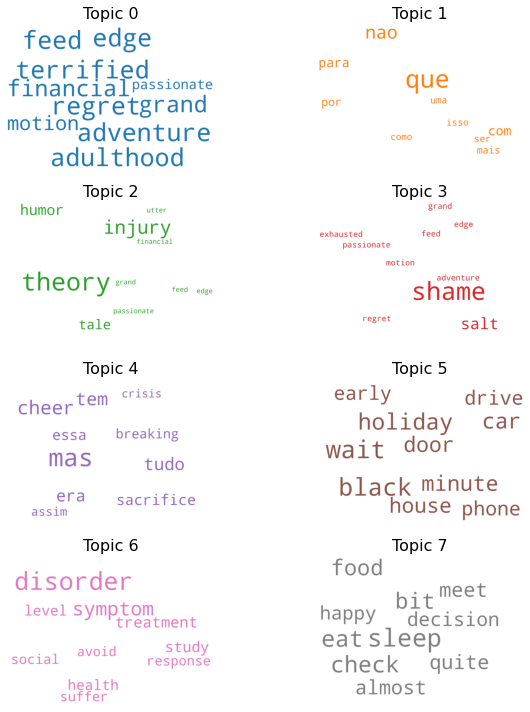

In [35]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(4, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [38]:
df_dominant_topic.to_csv("Medium2016.csv")

In [37]:
topic_words = []
num_topics = 42
for i in range(num_topics):
    tt = lda_model.get_topic_terms(i,10)
    topic_words.append([id2word[pair[0]] for pair in tt])
for i in range(0,num_topics):
    print(topic_words[i])    
df2=pd.DataFrame({'Year':[],'Source':[],'Topic_ID':[],'Most_freq_words':[]})
df2['Most_freq_words']=topic_words
df2 = df2.assign(Year=2014)
df2 = df2.assign(Source='Medium')
print(df2.shape)
ls=[]
for i in range(0,num_topics):
    ls.append(i)
df2['Topic_ID']=ls
df2

['mental_health', 'medication', 'doctor', 'issue', 'drug', 'support', 'therapy', 'suffer', 'mental_illness', 'health']
['job', 'company', 'career', 'pay', 'money', 'idea', 'quit', 'team', 'position', 'post']
['publish', 'oil', 'blood', 'popular', 'consciousness', 'remedy', 'movement', 'wide', 'product', 'wise']
['happy', 'happiness', 'sad', 'sadness', 'smile', 'content', 'drag', 'laugh', 'ignore', 'pretend']
['hospital', 'safety', 'safe', 'question', 'patient', 'nurse', 'valid', 'meditate', 'contemplate', 'puzzle']
['child', 'parent', 'baby', 'kid', 'filter', 'screen', 'eye_contact', 'harsh', 'cell', 'bet']
['emotion', 'negative', 'future', 'positive', 'allow', 'create', 'thinking', 'action', 'anger', 'choice']
['mom', 'mother', 'parent', 'dad', 'room', 'father', 'later', 'cry', 'throat', 'school']
['story', 'pain', 'realize', 'kind', 'yet', 'struggle', 'break', 'sense', 'instead', 'afraid']
['financial', 'os', 'passionate', 'terrified', 'grand', 'surge', 'final', 'adulthood', 'adventu

,Year,Source,Topic_ID,Most_freq_words
0,2014,Medium,0,"[mental_health, medication, doctor, issue, dru..."
1,2014,Medium,1,"[job, company, career, pay, money, idea, quit,..."
2,2014,Medium,2,"[publish, oil, blood, popular, consciousness, ..."
3,2014,Medium,3,"[happy, happiness, sad, sadness, smile, conten..."
4,2014,Medium,4,"[hospital, safety, safe, question, patient, nu..."
5,2014,Medium,5,"[child, parent, baby, kid, filter, screen, eye..."
6,2014,Medium,6,"[emotion, negative, future, positive, allow, c..."
7,2014,Medium,7,"[mom, mother, parent, dad, room, father, later..."
8,2014,Medium,8,"[story, pain, realize, kind, yet, struggle, br..."
9,2014,Medium,9,"[financial, os, passionate, terrified, grand, ..."


In [38]:
df2.to_csv("topic_words_m2016.csv")

In [25]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(alpha='auto', corpus=corpus, num_topics=num_topics, 
                                                id2word=dictionary, random_state=100)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [26]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=dict_tfidf_filtered, corpus=corpus, 
                                                        texts=data_lemmatized, start=2, limit=100, step=8)


range(2, 100, 8)
[0.40068400187362163, 0.3142196862104658, 0.2991711279719053, 0.2955690474247519, 0.29874404199304444, 0.3088294015500719, 0.31623212415366225, 0.3100875322112162, 0.31663944751462797, 0.3157236607460301, 0.2975287876559371, 0.3039623206343401, 0.29049389027425665]


(42, 0.01008535955702744, 0.3088294015500719)

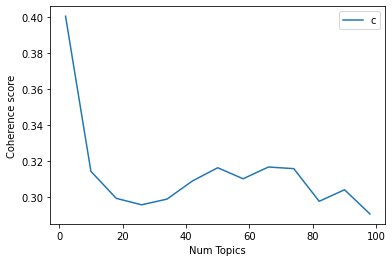

In [27]:
# Show graph
limit=100; start=2; step=8;
x = range(start, limit, step)
print(x)
print(coherence_values)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')

def differences(values, x):
    """
    Returns (optimal number of topics, largest jump, coherance value after jump)
    Params:
        values: list of coherance numbers, 
        x: num topics
    """
    max_diff = (0,0,0)
    for i in range(1,len(values)):
        if values[i]-values[i-1] > max_diff[1]:
            max_diff = (x[i], values[i]-values[i-1], values[i])
    return max_diff

differences(coherence_values, x)